# Introduction

The initial intuition that drives me to persue this project is that the DFT is inherently imperfect. The only way to precisely extract the exact frequencies in a signal is to run a DFT on an infinite number of buckets. And to perform a resolution between buckets to subtract nearby and aliased noise with an infinite number of recursions.

The starting assumption when performing a DFT is that there's some number of buckets for which the data loss associated with the bucketing is perceptually negligible. However, the sophistication of the human auditory system, much like the visual cortex, may actually make it easier to produce perceptually negligible in many cases. Collins (2010) points out that the human ear can be tricked to identify a frequency in audio that doesn't exist when the primary frequency is removed from a signal that includes the primary frequencies harmonics.

So the initial intuition is that we may be able to train a neural network to find the precise combination of frequencies that are interesting in a signal for performing a multi-label classification task.

## Input size

To add a dimension of challenge to having the neural network learn the DFT is that different frequencies require different input shapes for detection. Using a simple feed-forward network with a small input size should be able to capture high frequencies but low frequencies will be lost. And using a large input size will sufficiently capture lower frequencies in the signal, but may suffer from information loss if there is a lot of variance among the higher frequencies. So we have to add some complexity to address these issues.

One way we may handle this is to just increase the size / complexity of hidden layers in the model so as to capture multiple time series events. Another approach may be to use an RNN on a very short input signal that can feed back into itself for lower frequencies. Another approach is to try to use signaling neural network layers.

## Experiment

This experiment is to explore these domains to train a model that simply labels specific frequencies present in a static noisy signal. This doesn't require a data set because the signals can be synthesized from randomly constructed labels.

In [245]:
!pip install snntorch torch==1.11 numpy seaborn librosa tqdm torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

import math
import time
import numpy as np
import librosa as lr
from tqdm.notebook import tqdm, trange
import seaborn as sns
from IPython.display import Markdown, Audio
import matplotlib.pyplot as plt

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


# Training and testing infrastructure

First, the infrastructure for building data sets that we can use to test the model. 

## Label Generation

In [365]:
from torch.utils.data import Dataset, DataLoader


class GeneratedAudioDataSet(Dataset):
    SAMPLE_LENGTH = 96000
    FREQUENCY_COUNT = 48
    LABELED_FREQUENCIES = np.array([49, 220, 392, 880, 1760, 2093, 3520, 7040, 22000])
    FREQUENCY_LOOKUP = {k: i for i, k in enumerate(LABELED_FREQUENCIES)}
    
    def _freq(self, freq, offset):
        start = offset / freq
        end = self._il / freq
        t = np.linspace(start, start + end, num=self._il) * math.pi * 2
        return np.sin(t)
    
    def __init__(self, input_len, samples):
        self._il = input_len
      
        random_predefined = GeneratedAudioDataSet.LABELED_FREQUENCIES[np.random.randint(
            0, 
            len(GeneratedAudioDataSet.LABELED_FREQUENCIES),
            size=(samples, GeneratedAudioDataSet.FREQUENCY_COUNT))]
    
        freqs = np.random.randint(10, high=24000, size=(samples, GeneratedAudioDataSet.FREQUENCY_COUNT, 2));  
        use_predef = np.random.randint(0, 10, size=(samples, GeneratedAudioDataSet.FREQUENCY_COUNT)) == 0
        
        freqs[use_predef, 0] = random_predefined[use_predef]

        amps = 1 - np.random.power(4, (samples, GeneratedAudioDataSet.FREQUENCY_COUNT, 1))
        amps **= 2
        self._sigs = np.concatenate([freqs.astype(np.float64), amps], axis=2)

    @property
    def batch_size(self):
        return self._il
        
    def __len__(self):
        return int((self._sigs.shape[0] * GeneratedAudioDataSet.SAMPLE_LENGTH) / self._il)

    def __getitem__(self, index):
        idx = int(index / (96000 / self._il))
        offset = (index % (96000 / self._il)) * self._il
        
        labels = np.zeros(len(GeneratedAudioDataSet.LABELED_FREQUENCIES), dtype=np.float32)
        tone = np.zeros(self._il, dtype=np.float32)
        for s in range(0, GeneratedAudioDataSet.FREQUENCY_COUNT):
            tone += self._freq(self._sigs[idx, s, 0], offset + self._sigs[idx, s, 1]) * self._sigs[idx, s, 2]
            if self._sigs[idx, s, 0] in GeneratedAudioDataSet.FREQUENCY_LOOKUP:
                labels[GeneratedAudioDataSet.FREQUENCY_LOOKUP[self._sigs[idx, s, 0]]] = self._sigs[idx, s, 2]
        
        return tone, labels
    
def plot_and_display(ds, index=0):
    sample_len = int(96000 / ds.batch_size)
    sample = np.zeros(96000)
    
    start_basis = index * sample_len

    for i in trange(sample_len):
        st = i * ds.batch_size
        sample[st:st+ds.batch_size] = ds[start_basis + i][0]

    sns.lineplot(x = np.arange(sample.shape[0]), y=sample)
    display(Audio(sample, rate=48000))
    

# First pass

After endless headbanging - I switch gears to see if I can reproduce the behaviour of endolith where he managed to train a model to learn the DFT with incredible accuracy, albeit with less efficiency

In [406]:

class MSLELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.mse = nn.MSELoss(*args, **kwargs)
        
    def forward(self, pred, actual):
        return self.mse(torch.log(pred + 1), torch.log(actual + 1))

# After trying to use a simple feed-forward network to simply learn
# the amplitudes, I hit a brick wall at 65% accuracy. So before moving on,
# I will build this simple model and the initial training set to validate
# the work by endolith on creating an fft
class LearningFFT(nn.Module):
    
    def _train_epoch(self, batches):
        optimizer = optim.SGD(self.parameters(), lr=0.0001, momentum=0.99)
        criterion = MSLELoss(reduction='sum')
        
        running_loss = 0
        train_total = 0
        
        for i in range(batches):
            sig = ((torch.rand(100, self._isize) - 0.5) * 2).to(self.device)
            
            f = torch.fft.fft(torch.cos(sig * math.pi * 2) + 1j * torch.sin(sig * math.pi * 2))
            # f = torch.cat((f.real, f.imag), dim=1).to(self.device)
            f = torch.abs(f).to(self.device)

            # reset the optimizer
            optimizer.zero_grad()
            outputs = self(sig)
            loss = criterion(outputs, f)
            loss.backward()
            optimizer.step()
            
            # accumulate loss
            running_loss += loss.item()
            train_total += 1
            
        return running_loss / train_total
        
    def __init__(self, input_size, **kwargs):
        super().__init__()
        
        self._isize = input_size
        self._trained = False

        # simple first layer with no bias
        self.signal_layer = nn.Linear(input_size * 2, input_size * 2, bias=False)
        
        init_epochs = 200
        if 'fft_epochs' in kwargs:
            init_epochs = kwargs['fft_epochs']
            
        self._fftepochs = init_epochs
        self.train_fft()
            
    @property
    def device(self):
        return next(self.parameters()).device

    def train_fft(self):
        self._trained = True
        final_loss = 1e8
        
        for i in (ebar := trange(self._fftepochs)):
            ebar.set_description(f'Training FFT epoch {i} of {self._fftepochs} current loss: {final_loss:.2e}')
            final_loss = self._train_epoch(500)
        
    def forward(self, x):
        if not self._trained:
            raise ValueError("FFT is not yet trained... call train_fft")
        
        x = x.to(self.device)
        x = torch.mul(x, math.pi * 2)
        
        # convert the signal to the complex representation
        x = torch.cat((torch.cos(x), torch.sin(x)), dim=1)
        
        # clamp the signal from -1 to 1
        x = torch.clamp(x, min=-1, max=1)
        
        # the FFT is linear so this will be learned
        x = self.signal_layer(x)
        
        #return x
        
        # re-flatten the real and imaginary
        n = int(x.size(1) / 2)
        x = torch.sqrt(torch.pow(x[:, :n], 2) + torch.pow(x[:, n:], 2))
        return x;

    
fftmodel = LearningFFT(200)

  0%|          | 0/200 [00:00<?, ?it/s]

Real Mathematical DFT (196.708795 ms)

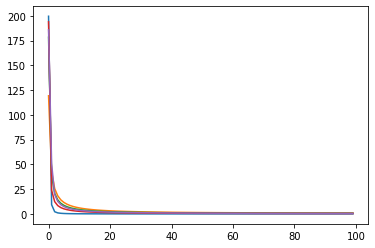

Learned equivalent of DFT (179.053681 ms)

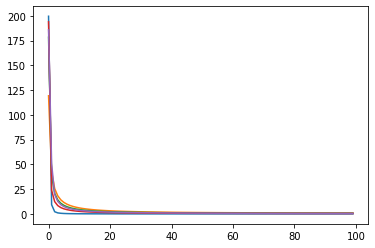

In [407]:
# Test that we got a decent fft

device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")
fftmodel.to(device)

ds = GeneratedAudioDataSet(200, 1)

start = time.process_time_ns()
for i in range(0, 20, 4):
    raw_signal = torch.tensor(ds[i][0] * 2 * math.pi)

    yf = torch.fft.fft(torch.cos(raw_signal) + 1j*torch.sin(raw_signal))
    yf = torch.abs(yf).numpy()
    yf = yf[:int(len(yf)/2)]

    sns.lineplot(x = np.arange(yf.shape[0]), y=yf)
    
end = time.process_time_ns()
display(Markdown(f'Real Mathematical DFT ({(end - start) / 1000000.0} ms)'))
plt.show()

start = time.process_time_ns()
for i in range(0, 20, 4):
    yf = fftmodel(torch.tensor(ds[i][0].reshape((1, ds[i][0].shape[0]))))[0]
    n = int(len(yf)/2)
    #yf = torch.sqrt(torch.pow(yf[:n], 2) + torch.pow(yf[n:], 2))
    yf = yf[:int(len(yf)/2)]
    yf = yf.detach().cpu().numpy()
    sns.lineplot(x = np.arange(yf.shape[0]), y=yf)

end = time.process_time_ns()
display(Markdown(f'Learned equivalent of DFT ({(end - start) / 1000000.0} ms)'))
plt.show()

In [587]:
class FrequencyFitModel(nn.Module):
    
    def __init__(self, input_size, **kwargs):
        super().__init__()
        
        self._isize = input_size
        
        self.freq_layer = LearningFFT(input_size, **kwargs)
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.hidden_layer = nn.Linear(input_size, 64, bias=False)
        self.output_layer = nn.Linear(64, len(GeneratedAudioDataSet.LABELED_FREQUENCIES))

    @property
    def device(self):
        return self.freq_layer.device
        
    def forward(self, x):
        x = x.to(self.device)
        x = self.freq_layer(x)
        x = self.batch_norm(x)
        x = torch.sigmoid(x)
        
        x = self.hidden_layer(x)
        x = torch.sigmoid(x)
        x = self.output_layer(x)
        return torch.sigmoid(x);
    
def fit_model(model, ds, **kwargs):
    train_size = int(0.8 * len(ds))
    validation_size = len(ds) - train_size
    train_dataset, validation_dataset = torch.utils.data.random_split(ds, [train_size, validation_size])

    batch_size=16
    if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']
    
    epochs = 10
    if 'epochs' in kwargs:
        epochs = kwargs['epochs']
    
    criterion = None
    if 'loss' in kwargs:
        criterion = kwargs['loss']
    else:
        criterion = nn.BCELoss()
        
    optimizer = None
    if 'optimizer' in kwargs:
        optimizer = kwargs['optimizer']
    else:
        optimizer = optim.SGD(model.parameters())

    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(validation_dataset, batch_size=100)
        
    epoch_stats = []
    for epoch in range(epochs):
    
        # track total loss
        running_loss = 0.0
        train_total = 0
        
        # training
        for batch in tqdm(loader):
            X, Y = batch

            # zero gradients
            optimizer.zero_grad()
            outputs = model(X.to(model.device))
            loss = criterion(outputs, Y.to(model.device))
            loss.backward()
            optimizer.step()
            
            # accumulate loss
            running_loss += loss.item()
            train_total += 1
         
        # validation
        with torch.no_grad():
            total = 0
            correct = 0
            label_total = 0
            valid_loss = 0.0
            
            for batch in valid_loader:
                X, Y = batch
                X = X.to(model.device)
                Y = Y.to(model.device)
                
                outputs = model(X)
                
                loss = criterion(outputs, Y)
                valid_loss += loss.item()
                correct += (torch.round(outputs, decimals=3) == torch.round(Y, decimals=3)).sum().item()
                total += 1
                label_total += Y.nelement()

            epoch_stats.append({
                'train_loss': running_loss / train_total,
                'valid_loss': valid_loss / total,
                'accuracy': correct / label_total
            })
            
            print(f'Epoch {epoch + 1}')
            print(f'Training Loss:   {epoch_stats[-1]["train_loss"]}')
            print(f'Validation Loss: {epoch_stats[-1]["valid_loss"]}')
            print(f'Accuracy:        {epoch_stats[-1]["accuracy"]}')
            print()
            
    return epoch_stats

ds = GeneratedAudioDataSet(240, 100)
#model = FrequencyFitModel(ds.batch_size, fft_epochs=35)
#model.to(device)

fit_model(
    model, 
    ds,
    batch_size=25,
    loss=nn.L1Loss(reduction='sum'),
    optimizer=optim.NAdam(model.parameters(), lr=0.001),
    epochs=10)

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch 1
Training Loss:   6.630472582578659
Validation Loss: 26.005778646469118
Accuracy:        0.5614861111111111



  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch 2
Training Loss:   6.550519282184541
Validation Loss: 25.812892031669616
Accuracy:        0.5661666666666667



  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch 3
Training Loss:   6.472451813519001
Validation Loss: 25.296306991577147
Accuracy:        0.5552638888888889



  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch 4
Training Loss:   6.38708631247282
Validation Loss: 25.12952959537506
Accuracy:        0.5719444444444445



  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch 5
Training Loss:   6.337385793589055
Validation Loss: 24.948122644424437
Accuracy:        0.5705416666666666



  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch 6
Training Loss:   6.305066859535873
Validation Loss: 24.83674912452698
Accuracy:        0.5760833333333333



  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch 7
Training Loss:   6.2841600347310305
Validation Loss: 24.80617184638977
Accuracy:        0.5860555555555556



  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch 8
Training Loss:   6.268371475301683
Validation Loss: 24.76864891052246
Accuracy:        0.5784583333333333



  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch 9
Training Loss:   6.258212683163583
Validation Loss: 24.667115688323975
Accuracy:        0.5864305555555556



  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch 10
Training Loss:   6.250789280980825
Validation Loss: 24.678206515312194
Accuracy:        0.5844305555555556



[{'train_loss': 6.630472582578659,
  'valid_loss': 26.005778646469118,
  'accuracy': 0.5614861111111111},
 {'train_loss': 6.550519282184541,
  'valid_loss': 25.812892031669616,
  'accuracy': 0.5661666666666667},
 {'train_loss': 6.472451813519001,
  'valid_loss': 25.296306991577147,
  'accuracy': 0.5552638888888889},
 {'train_loss': 6.38708631247282,
  'valid_loss': 25.12952959537506,
  'accuracy': 0.5719444444444445},
 {'train_loss': 6.337385793589055,
  'valid_loss': 24.948122644424437,
  'accuracy': 0.5705416666666666},
 {'train_loss': 6.305066859535873,
  'valid_loss': 24.83674912452698,
  'accuracy': 0.5760833333333333},
 {'train_loss': 6.2841600347310305,
  'valid_loss': 24.80617184638977,
  'accuracy': 0.5860555555555556},
 {'train_loss': 6.268371475301683,
  'valid_loss': 24.76864891052246,
  'accuracy': 0.5784583333333333},
 {'train_loss': 6.258212683163583,
  'valid_loss': 24.667115688323975,
  'accuracy': 0.5864305555555556},
 {'train_loss': 6.250789280980825,
  'valid_loss':

In [502]:

ds = GeneratedAudioDataSet(240, 5)

display(model(torch.tensor(ds[0][0]).reshape(1, 240).to(model.device)).detach().cpu().numpy()[0])
display(ds[0][1].astype(np.float32))

array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

array([0.        , 0.04998812, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.26614538, 0.        ], dtype=float32)